In [ ]:
import sys

sys.path.append("../")

A place to test random stuff

In [ ]:
from monkey.model.classification_model.efficientnet_b0 import (
    EfficientNet_B0,
)
import torch
import torch.nn as nn
from monkey.model.utils import (
    get_classification_metrics,
    get_activation_function,
)
from monkey.model.loss_functions import get_loss_function, dice_coeff
import numpy as np
from pprint import pprint

In [ ]:
true_mask = np.zeros(shape=(1, 2, 256, 256), dtype=np.float32)
true_mask[0, 0, :, :] = 1
true_mask = torch.tensor(
    true_mask, dtype=torch.float32, requires_grad=True
)

# pprint(true_mask)
pred_mask = np.zeros(shape=(1, 2, 256, 256), dtype=np.float32)
pred_mask[0, 0, :, :] = 1
pred_mask[0, 1, :, :] = 1
pred_mask = torch.tensor(
    pred_mask, dtype=torch.float32, requires_grad=True
)

dice_loss_fn = get_loss_function("Dice")
dice_loss_fn.set_multiclass(True)

dice_loss = dice_loss_fn.compute_loss(true_mask, pred_mask)

pprint(dice_loss)

CONCH

In [ ]:
from conch.open_clip_custom import (
    create_model_from_pretrained,
    tokenize,
    get_tokenizer,
)
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
model_cfg = "conch_ViT-B-16"
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
checkpoint_path = "/home/u1910100/Downloads/pytorch_model.bin"
model, preprocess = create_model_from_pretrained(
    model_cfg, checkpoint_path, device=device
)
_ = model.eval()

tokenizer = get_tokenizer()
classes = ["lymphocyte", "monocyte"]
prompts = [
    "a PAS stained image of a lymphocyte",
    "a PAS stained image of a monocyte",
]

tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(
    device
)
tokenized_prompts.shape

In [ ]:
from monkey.data.dataset import get_classification_dataloaders
from monkey.config import TrainingIOConfig

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/classification",
    save_dir="./",
)
IOconfig.set_image_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
batch_size = 32
train_loader, val_loader = get_classification_dataloaders(
    IOconfig,
    val_fold=1,
    batch_size=batch_size,
    do_augmentation=True,
)

In [ ]:
pred_probs_list = []
true_labels_list = []

for data in tqdm(val_loader):
    file_ids = data["id"]

    images, true_labels = (
        data["image"].cuda().float(),
        data["label"].cpu().tolist(),
    )

    true_labels_list.extend(true_labels)
    pred_probs = []

    with torch.inference_mode():
        image_embedings = model.encode_image(images)
        text_embedings = model.encode_text(tokenized_prompts)
        sim_scores = (
            (
                image_embedings
                @ text_embedings.T
                * model.logit_scale.exp()
            )
            .softmax(dim=-1)
            .cpu()
            .numpy()
        )

        pred_probs_list.extend(sim_scores[:, 1])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from monkey.model.utils import get_classification_metrics

pred_probs_list = np.array(pred_probs_list)
true_labels_list = np.array(true_labels_list)
fpr, tpr, thresholds = metrics.roc_curve(
    true_labels_list, pred_probs_list
)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name="cell classifier",
)
display.plot()
plt.show()

thresh = 0.5
pred_labels_list = np.where(pred_probs_list > thresh, 1, 0)
scores = get_classification_metrics(
    true_labels_list, pred_labels_list
)
print(scores)
metrics.ConfusionMatrixDisplay.from_predictions(
    true_labels_list,
    pred_labels_list,
    display_labels=["lymphocyte", "monocyte"],
)
plt.show()

In [ ]:
data = next(iter(val_loader))
images = data["image"].to("cuda").float()
print(data["label"])

with torch.inference_mode():
    image_embedings = model.encode_image(images)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (
        (image_embedings @ text_embedings.T * model.logit_scale.exp())
        .softmax(dim=-1)
        .cpu()
        .numpy()
    )

pred_class = sim_scores.argmax()
print(pred_class)
print(sim_scores)
print(sim_scores[:, 1])
# print("Predicted class:", classes[sim_scores.argmax()])
# print(
#     "Normalized similarity scores:",
#     [
#         f"{cls}: {score:.3f}"
#         for cls, score in zip(classes, sim_scores[0])
#     ],
# )

CellViT

In [ ]:
import torch
from monkey.model.cellvit.cellvit import CellViT256

model_path = "/home/u1910100/Downloads/CellViT-256-x40.pth"
device = "cuda"

model_checkpoint = torch.load(model_path)
print(model_checkpoint["arch"])
print(model_checkpoint["config"])

model = CellViT256(
    model256_path=None,
    num_nuclei_classes=6,
    num_tissue_classes=19,
    regression_loss=False,
)

model.load_state_dict(model_checkpoint["model_state_dict"])

model.eval()
model.to("cuda")

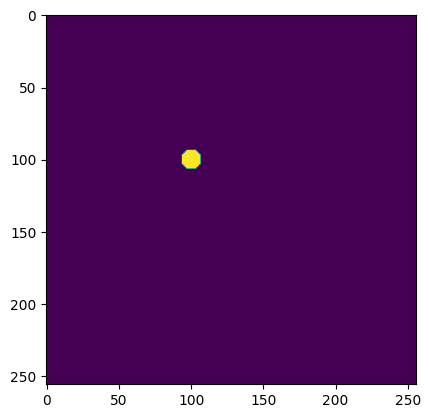

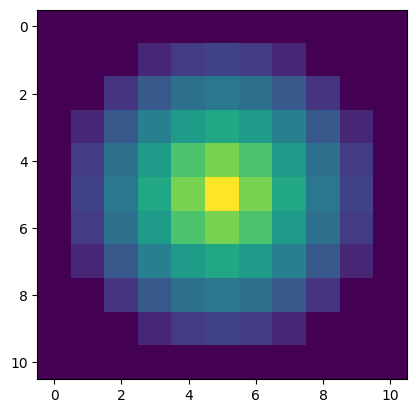

6643.552


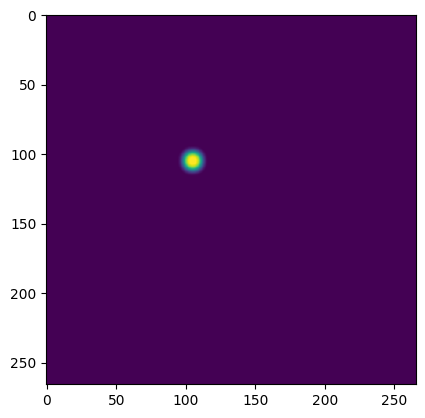

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from scipy import ndimage, signal

sys.path.append("../")
from monkey.data.data_utils import erode_mask, generate_regression_map
import cv2
from skimage import draw

cell_mask = np.zeros(shape=(256,256), dtype = np.uint8)
rr, cc = draw.ellipse(100, 100, 7, 7, shape=cell_mask.shape)
# rr, cc = 100, 100
cell_mask[rr,cc] = 255
plt.imshow(cell_mask)
plt.show()

dist_filter = np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [
                0.0,
                0.0,
                0.0,
                0.1055728,
                0.17537889,
                0.2,
                0.17537889,
                0.1055728,
                0.0,
                0.0,
                0.0,
            ],
            [
                0.0,
                0.0,
                0.1514719,
                0.27888975,
                0.36754447,
                0.4,
                0.36754447,
                0.27888975,
                0.1514719,
                0.0,
                0.0,
            ],
            [
                0.0,
                0.1055728,
                0.27888975,
                0.43431458,
                0.5527864,
                0.6,
                0.5527864,
                0.43431458,
                0.27888975,
                0.1055728,
                0.0,
            ],
            [
                0.0,
                0.17537889,
                0.36754447,
                0.5527864,
                0.71715724,
                0.8,
                0.71715724,
                0.5527864,
                0.36754447,
                0.17537889,
                0.0,
            ],
            [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0],
            [
                0.0,
                0.17537889,
                0.36754447,
                0.5527864,
                0.71715724,
                0.8,
                0.71715724,
                0.5527864,
                0.36754447,
                0.17537889,
                0.0,
            ],
            [
                0.0,
                0.1055728,
                0.27888975,
                0.43431458,
                0.5527864,
                0.6,
                0.5527864,
                0.43431458,
                0.27888975,
                0.1055728,
                0.0,
            ],
            [
                0.0,
                0.0,
                0.1514719,
                0.27888975,
                0.36754447,
                0.4,
                0.36754447,
                0.27888975,
                0.1514719,
                0.0,
                0.0,
            ],
            [
                0.0,
                0.0,
                0.0,
                0.1055728,
                0.17537889,
                0.2,
                0.17537889,
                0.1055728,
                0.0,
                0.0,
                0.0,
            ],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        ], dtype=np.float32)

plt.imshow(dist_filter)
plt.show()
# cell_mask = generate_regression_map(cell_mask, d_thresh=5, alpha=0.5, scale=1)
# plt.imshow(cell_mask)
# plt.show()

cell_mask = signal.convolve2d(
    cell_mask, dist_filter
)
print(np.max(cell_mask))
plt.imshow(cell_mask)
plt.show()

In [ ]:
import sys

sys.path.append("../")

import torch

torch.manual_seed(0)
from torchvision.models.efficientnet import (
    efficientnet_b0,
)
from monkey.model.efficientunetb0.architecture import (
    EfficientUnet_MBConv,
    EfficientUnet_MBConv_Multihead,
)
from torchinfo import summary

encoder = efficientnet_b0()
encoder = encoder.features

model_2 = EfficientUnet_MBConv_Multihead(
    encoder, num_heads=2, decoders_out_channels=[2, 1]
)
model_2.eval()
summary(model_2, input_size=(1, 3, 256, 256))

In [ ]:
with torch.no_grad():
    test_input = torch.ones(size=(1, 3, 256, 256))

    model_2_out = model_2(test_input)
    print(model_2_out)